In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

In [6]:
# Initialize matplotlib for LaTeX
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{bm}')

# Plan for simple custom Laplacian

Let's try to make a prediction of the shape of eigenvalues of a matrix formed as $a \tanh(bD) + A$ for $a, b \in \mathbb{R}$ parameters (we'll want to change these to see if our prediction tracks empirical data).

My guess is that this will behave as though $D$ is a diagonal of iid $\mathcal{N}(0, 1)$ variables and $A$ is a GOE matrix. In that case, the eigenvalue distribution should be

$$ a \tanh(b\mathcal{N}(0, 1)) \boxplus \mu_{\mathsf{SC}} $$

Here is a plan to numerically estimate this density.

## General additive free convolution with semicircle

Paralleling the covariance situation, we can write a general formula for $G_{\nu \boxplus \mu_{\mathsf{SC}}}$.
Recall that we have

$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}^{-1}(z) - \frac{1}{z} = R_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = R_{\nu}(z) + z = G_{\nu}^{-1}(z) - \frac{1}{z} + z $$

Rearranging this gives the implicit equation

$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = G_{\nu}(z - G_{\nu \boxplus \mu_{\mathsf{SC}}}(z)) $$

and expanding the definition of $G_{\nu}$ on the right gives

$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = \int \frac{1}{z - G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) - t} d\nu(t) $$

exactly paralleling the covariance version below.

## Plugging in transformed Gaussian

We want to use this with $\nu = \phi(\mathcal{N}(0, 1))$ for some $\phi$ (for us $\phi(t) = a\tanh(bt)$, but other sigmoids / other functions in general also make sense). You can actually just substitute this directly into the Stieltjes transform equation without explicitly calculating the density of $\phi(\mathcal{N}(0, 1))$:


$$ G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) = \int \frac{1}{z - G_{\nu \boxplus \mu_{\mathsf{SC}}}(z) - \phi(g)} \frac{1}{\sqrt{2\pi}} e^{-g^2/2} dg $$

<span style="color:red">Our situation is different than the covariance estimation one:</span> There the unknown was the measure $\nu$ on the right, while here it is $\nu \boxplus \mu_{\mathsf{SC}}$ on the left. But, I think we can follow a somewhat similar approach. Fix a grid of $z_j = x_j + i\epsilon$ close to the real axis. Call $G_j = G_{\nu \boxplus \mu_{\mathsf{SC}}}(z_j)$. These numbers satisfy the fixed-point equation

$$ G_j = \int \frac{1}{z_j - G_j - \phi(g)} \frac{1}{\sqrt{2\pi}} e^{-g^2/2} dg $$

We can (hopefully) solve this by just iterating the above map, i.e., by running a numerical integration of

$$ G_j^{(t + 1)} = \int \frac{1}{z_j - G_j^{(t)} - \phi(g)} \frac{1}{\sqrt{2\pi}} e^{-g^2/2} dg $$

until convergence (say, until $|G_j^{(t + 1)} - G_j^{(t)}|$ becomes sufficiently small). To recovery the density of $\nu \boxplus \mu_{\mathsf{SC}}$, we can use the Stieltjes inversion formula: if this density is $\rho$, then

$$ \rho(x) = \lim_{\epsilon \to 0} -\frac{1}{\pi} \mathsf{Im}(G_{\nu \boxplus \mu_{\mathsf{SC}}}(x + it)) $$

In particular, for $\epsilon$ small enough, we should have

$$ \rho(x_j) \approx -\frac{1}{\pi} \mathsf{Im}(G_j), $$

giving us a sequence of point values of estimates of the density.

## Better sigmoid?

One small comment: another reasonable choice of nonlinearity is $\phi(t) = t / \sqrt{1 + t^2}$, a different shape of sigmoid. For this one, it seems Mathematica is able to calculate $G_{\nu}(z)$ above for any given $z$ in closed form fairly quickly (though, weirdly, not for general $z$), so you could try this if the above numerical strategy has problems.

# <span style="color:red">Covariance estimation code</span>

<span style="color:red">NOTE: I don't think this will actually be useful, but I had already put it in here, so including just in case.</span>

This generates the example of covariance estimation figure from my lecture notes.

Recall that this is using the formula for multiplicative free convolution with Marchenko-Pastur, that for any compactly supported probability measure $\mu$,

$$ G_{\mu \boxtimes \mu_{\mathsf{MP}(c)}}(z) = \int \frac{1}{z - x(1 - c + cz G_{\mu \boxtimes \mu_{\mathsf{MP}(c)}}(z))} d\mu(x). $$

In [2]:
d = 500
m = 2500

In [3]:
# True eigenvalues: half at 1, half at 2
Sigma = np.zeros((d, d))
for i in range(d):
    if i % 2 == 0:
        Sigma[i, i] = 1
    else:
        Sigma[i, i] = 2

In [4]:
# Generate synthetic data and sample covariance    
Sigma_sqrt = np.sqrt(Sigma)
G = np.random.normal(size=(d, m))
X = Sigma_sqrt @ G
Sigma_hat = X @ X.T / m

In [10]:
# Grid sizes
num_ts = 15
num_zs = 50
z_imag_part = 1.

# Generate grids
ts = np.linspace(0.5, 3.0, num_ts)
zs_x = np.linspace(0.0, 5.0, num_zs)
zs = np.hstack([zs_x + z_imag_part * 1.j])

evals = np.linalg.eigvalsh(Sigma_hat)

# Build matrices to express the above equation between Stieltjes transforms of observation and input
G_hats = np.zeros(num_zs, dtype=np.complex256)
G_mat = np.zeros((num_zs, num_ts), dtype=np.complex256)
for b in range(num_zs):
    G_hats[b] = 1.0 / d * (1.0 / (zs[b] - evals)).sum()
    
for a in range(num_ts):
    for b in range(num_zs):
        G_mat[b, a] = 1.0 / (zs[b] - ts[a] * (1. - d/m + d/m * zs[b] * G_hats[b]))
        
# cvxpy linear program
ws = cv.Variable(num_ts)
G_err = cv.hstack([G_mat.real @ ws - G_hats.real, G_mat.imag @ ws - G_hats.imag])
# Minimize infinity norm => linear program
objective = cv.Minimize(cv.norm(G_err, p='inf'))
constraints = [ws >= 0, cv.sum(ws) == 1]
prob = cv.Problem(objective, constraints)

value = prob.solve(solver='MOSEK')
print(value)

0.0005797104157126975


In [8]:
# Truncate to only include the point masses with enough mass
ws_nonzero = ws.value[ws.value > 1e-2]
ts_nonzero = ts[ws.value > 1e-2]

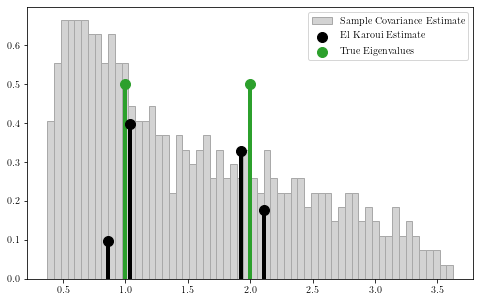

In [9]:
plt.subplots(figsize=(8, 5))

_ = plt.hist(np.linalg.eigvalsh(Sigma_hat), bins=60, density=True, label='$\\textrm{Sample Covariance Estimate}$', facecolor='lightgray', edgecolor='darkgray', linewidth=1)

plt.scatter(ts_nonzero, ws_nonzero, color='black', s=100, zorder=10, label='$\\textrm{El Karoui Estimate}$')
for i in range(ws_nonzero.shape[0]):
    plt.vlines(ts_nonzero[i], 0.0, ws_nonzero[i], linewidth=4, zorder=10)
    
ws_true = np.array([0.5, 0.5])
ts_true = np.array([1.0, 2.0])

plt.scatter(ts_true, ws_true, color=(0.172549,0.627451,0.172549), s=100, zorder=5, label='$\\textrm{True Eigenvalues}$')
for i in range(ws_nonzero.shape[0]):
    plt.vlines(ts_true, 0.0, ws_true, color=(0.172549,0.627451,0.172549), zorder=5, linewidth=4)
    
plt.legend()